## Permutation Tests for Dummies

If you search "permutation test" on Wikipedia, you get the following definition:

> A permutation test (also called re-randomization test) is an exact statistical hypothesis test making use of the proof by contradiction in which the distribution of the test statistic under the null hypothesis is obtained by calculating all possible values of the test statistic under possible rearrangements of the observed data. 

What does it mean? In this tutorial we are going to see in detail what this definition means, how to implement permutation tests, and their pitfalls.

## Example 1: is a coin fair?

Let's start with an example: suppose you wanted to test whether a coin is fair. You throw the coin 10 times and you count the number of times you get heads. Let's simulate the outcome.

In [1]:
import numpy as np

np.random.seed(1)
np.random.binomial(1, 0.5, 10)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

Out of 10 coin throws, we got only 2 heads. Does it mean that the coin is not fair?

The **question** that permutation testing is trying to answer is "*how unlikely is the observed outcome under the null hypothesis that the coin is fair?*". 

In this case we can directly compute this answer since we have a very little number of throws. The total number of outcomes is $2^{10}$. The number of as or more extreme outcomes, under the assumption that the coin is fair (50-50) is

- 0 heads: ${10 \choose 0} = 1$
- 1 head: ${10 \choose 1} = 10$
- 2 heads: ${10 \choose 2} = 45$

So that the probability of getting the same or a more extreme outcome is

In [2]:
from scipy.special import comb

(comb(10, 0) + comb(10, 1) + comb(10, 2)) / 2**10

0.0546875

This probability seems low but not too low. 

However, we have forgot one thing. We want to test whether the coin is fair in **either** direction. We would suspect that the coin is unfair if we were getting few heads (as we did), but also if we were getting many heads. Therefore, we should account for both extremes.

In [3]:
sum([comb(10, i) for i in [0, 1, 2, 8, 9, 10]]) / 2**10

0.109375

This number should not be surprising since it's exactly double the previous one.

It is common in statistics to say that an event is unusual if its probability is less than 1 in 20, i.e. $5\%$. If we were adopting that threshold, we would not conclude that getting 2 heads in 10 trows is so unusual. However, getting just one, would be.

In [4]:
sum([comb(10, i) for i in [0, 1, 9, 10]]) / 2**10

0.021484375

## Hypothesis Testing

The process we just went through is called **hypothesis testing**. The components of an hypothesis test are:

1. A null hypothesis $H_0$
    - in our case, that the coin war fair

2. A test statistic $t$
    - in our case, the number of zeros

3. A level of significance $\alpha$
    - it is common to choose 5%
    
The **idea** behind **permutation testing** is the following: in a setting in which we are checking whether one variable has an effect on another variable, the two variables should not be correlated, under the null hypothesis . Therefore, we could re-shuffle the treatment variable and re-compute the test statistic. Lastly, we can compute the p-value as the fraction of as or more extremes outcomes under re-shuffling of the data.

## Example 2: are women smarter?

Suppose now we were interested in knowing whether females perform better in a test than men. Let's start by writing the data generating process under the assumption of no difference in scores. However, only 30% of the sample will be female.

In [5]:
import pandas as pd

# Data generating process
def generate_data_gender(N=100, seed=1):
    np.random.seed(seed) # Set seed for replicability
    data = pd.DataFrame({"female": np.random.binomial(1, 0.3, N),
                         "test_score": np.random.exponential(3, N)})
    return data

Let's now generate a sample of size 100.

In [6]:
# Generate data
data_gender = generate_data_gender()
data_gender.head()

,female,test_score
0,0,1.186447
1,1,2.246348
2,0,6.513147
3,0,1.326091
4,0,7.175402


We can compute the treatment effect by computing the difference in mean outcomes between male and females.

In [7]:
def compute_score_diff(data):
    T = np.mean(data.loc[data['female']==1, 'test_score']) - np.mean(data.loc[data['female']==0, 'test_score'])
    return T

In [8]:
T = compute_score_diff(data_gender)
print(f"The estimated treatment effect is {T}")

The estimated treatment effect is -1.3612262580563321


It looks that females actually did worse than males. But is the difference statistically significant? We can perform a randomization test and compute the probability of observing a more extreme outcome.

First, let's write the permutation routine that takes a variable in the data and permutes it.

In [9]:
def permute(data, var, r):
    temp_data = data.copy()
    temp_data[var] = np.random.choice(data[var], size=len(data), replace=r)
    return temp_data

We can now write the permutation test. It spits out a vector of statistics and prints the implied p-value.

In [10]:
def permutation_test(data, permute, var, compute_stat, K=1000, r=False):
    T = compute_stat(data)
    T_perm = []
    for k in range(K):
        temp_data = permute(data, var, r)
        T_perm += [compute_stat(temp_data)]
    print(f"The p-value is {sum(np.abs(T_perm) >= np.abs(T))/K}")
    return T_perm

In [11]:
Ts = permutation_test(data_gender, permute, 'test_score', compute_score_diff)

The p-value is 0.063


Apparently the result we have observed was quite unusual, but not at the 5% level. We can plot the distribution of statistics to visualize this result.

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from src.utils import *

In [13]:
def plot_test(T, Ts, title):
    plt.hist(Ts, density=True, bins=30, alpha=0.7, color='C0')
    plt.vlines([-T, T], ymin=plt.ylim()[0], ymax=plt.ylim()[1], color='C2')
    plt.title(title);

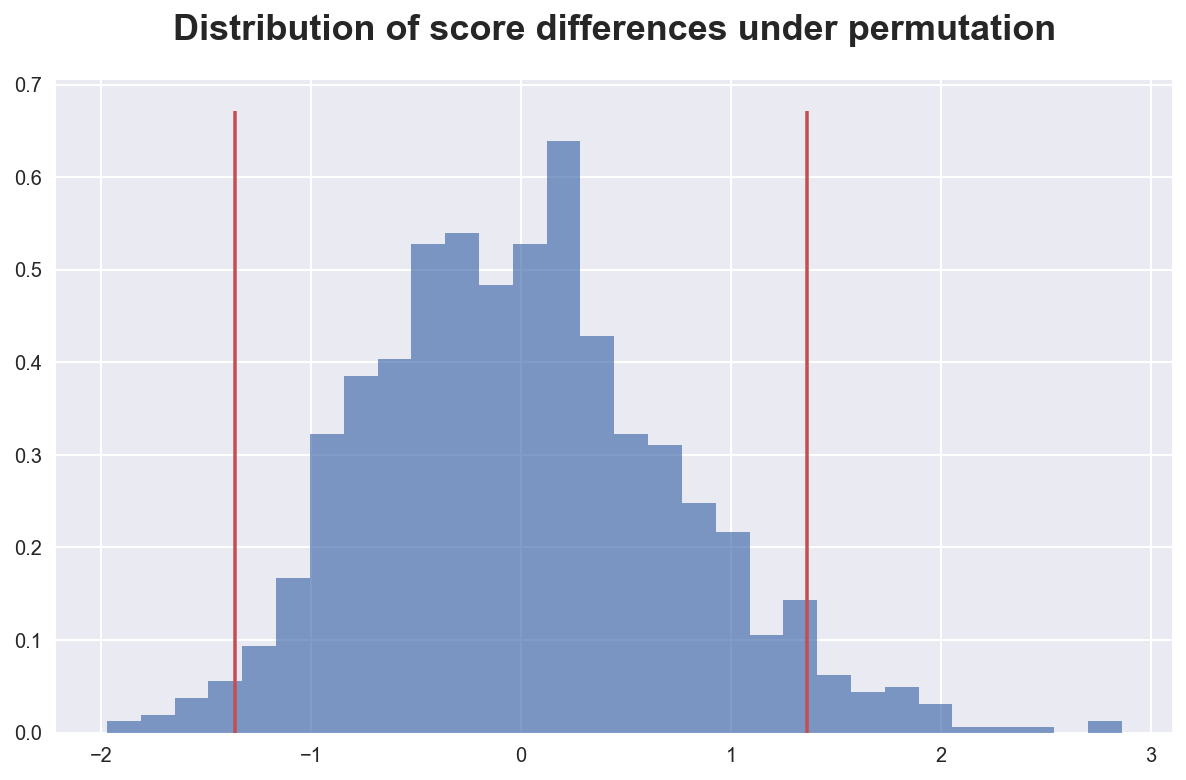

In [14]:
plot_test(T, Ts, 'Distribution of score differences under permutation')

As we can see, the observed difference in scores is quite extreme with respect the distribution generate by the permutation.

One **issue** with the permutation test we just ran is that it is computationally expensive to draw without replacement. The standard and much faster procedure is to draw without replacement.

In [15]:
Ts_repl = permutation_test(data_gender, permute, 'test_score', compute_score_diff, r=True)

The p-value is 0.052


The p-value is virtually the same.

How **accurate** is the test? Since we have access to the data generating process, we can compute the true p-value via simulation. We draw many samples from the true data generating process and, for each, compute the difference in scores. The simulated p-value is going to be the frequency of more extreme statistics.

In [16]:
# Function to simulate data and compute pvalue
def simulate_stat(dgp, compute_stat, K=1000):
    T = compute_stat(dgp())
    T_sim = []
    for k in range(K):
        data = dgp(seed=k)
        T_sim += [compute_stat(data)]
    print(f"The p-value is {sum(np.abs(T_sim) >= np.abs(T))/K}")
    return np.array(T_sim)

In [17]:
T_sim = simulate_stat(generate_data_gender, compute_score_diff)

The p-value is 0.038


Again, we can plot the distribution of simulated statistics to understand the computed p-value.

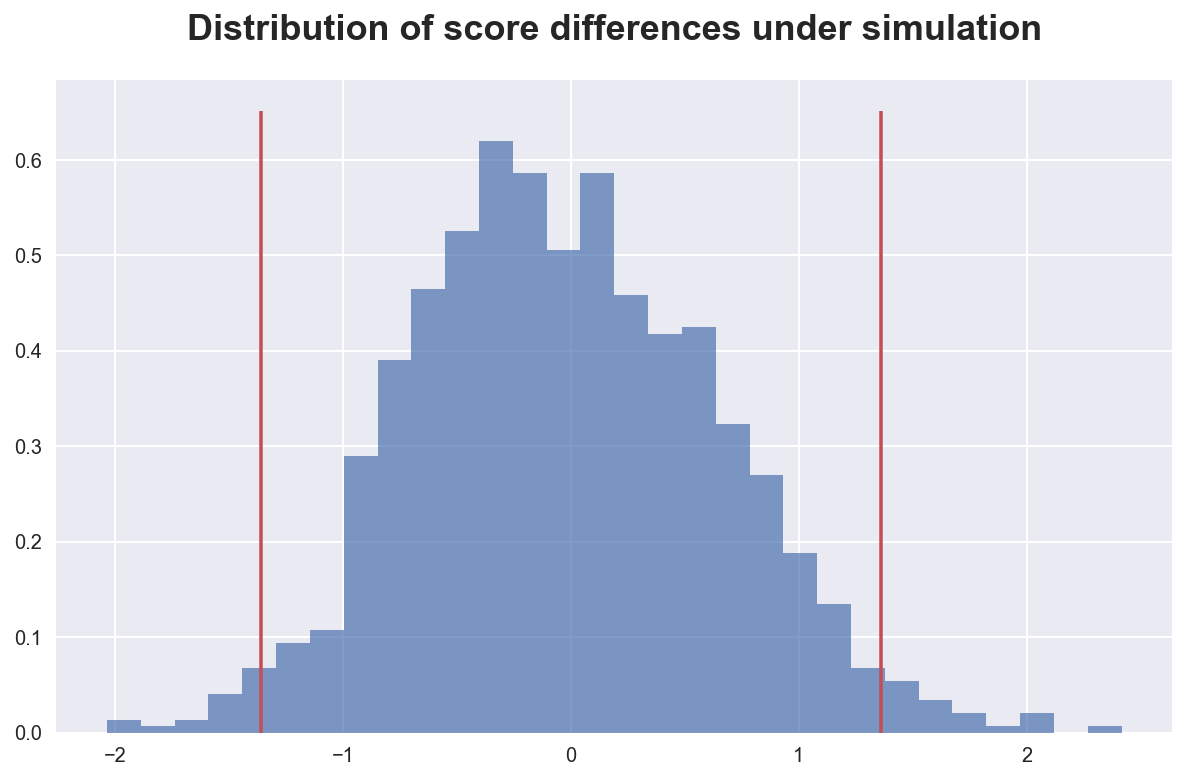

In [18]:
plot_test(T, T_sim, 'Distribution of score differences under simulation')

As expected, most of the mass lies within the interval, indicating a relatively extreme result. We have just been "unlucky" with the draw, but the permutation test was accurate.

## Permutation tests vs t-tests

What is the difference between a t-test and a permutation test? 

Permutation test **advantages**:

- does not make distributional assumptions
- not sensible to outliers
- can be computed also for statistics whose distribution is not known

Permutation test **disadvantages**:

- computationally intense
- very sample-dependent

## Example 3: is university worth?

Let's now switch to a new example to compare t-tests and permutation tests.

Assume we want to check whether university is a worthy investment. We have information about whether individuals attended university and their future salary. The problem here is that income is a particularly **skewed** variable.

In [19]:
# Data generating process
def generate_data_income(N=1000, seed=1):
    np.random.seed(seed) # Set seed for replicability
    university = np.random.binomial(1, 0.5, N) # Treatment
    data = pd.DataFrame({"university": university,
                         "income": np.random.lognormal(university, 2.3, N)})
    return data

In [20]:
data_income = generate_data_income()
data_income.head()

,university,income
0,0,5.305618
1,1,1.289598
2,0,6.507720
3,0,6.019961
4,0,0.034482


The distribution of income is very heavy tailed. Let's plot its density across the two groups.

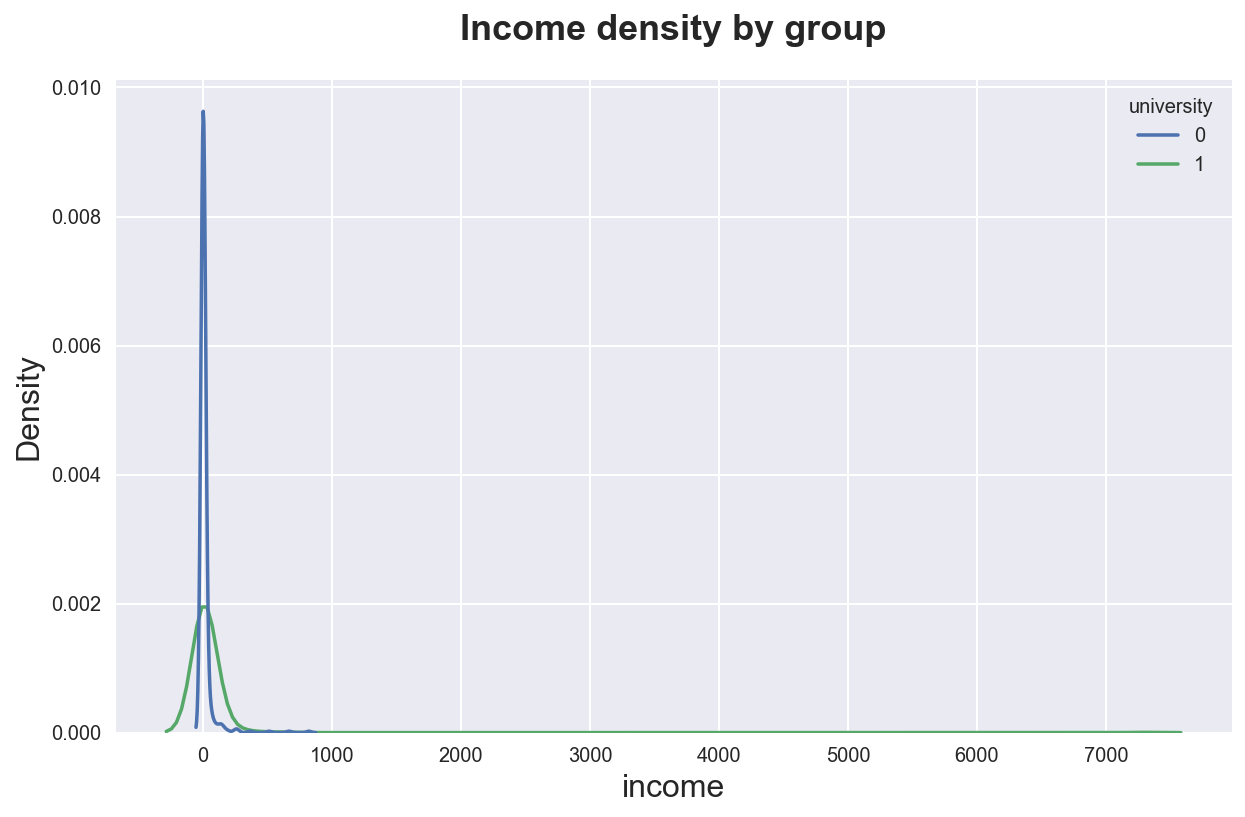

In [21]:
sns.kdeplot(data=data_income, x="income", hue="university")\
.set(title='Income density by group');

The distribution is so skewed that we cannot actually visually perceive differences between the two groups. Let's compute the expected difference.

In [22]:
def compute_income_diff(data):
    T = np.mean(data.loc[data['university']==1, 'income']) - np.mean(data.loc[data['university']==0, 'income'])
    return T

In [23]:
T = compute_income_diff(data_income)
T

23.546974435985444

It looks like university graduates have higher income. Is this difference statistically different from zero? Let's perform a permutation test.

In [24]:
T_perm = permutation_test(data_income, permute, 'university', compute_income_diff)

The p-value is 0.011


The permutation test is telling us that the difference is extremely unusual under the null hypothesis. In other words, it is very unlikely that university graduates earn the same income of non-university graduates.

What would be the outcome of a standard t-test?

In [25]:
from scipy.stats import ttest_ind

ttest_ind(data_income.query('university==1')['income'], data_income.query('university==0')['income'])

Ttest_indResult(statistic=1.5589492598056494, pvalue=0.1193254252009701)

As we can see, the two tests provide extremely different results. The t-test is much more conservative, telling us that the unlikeliness of the data is just $12\%$ compared to the $1.1\%$ of the permutation test. 

The **reason** is that we have extremely skewed data. The t-test is very sensible to extreme observation and will therefore compute a very high variance because of very few data points.

The permutation test can further address the problem of a skewed outcome distribution by using a test statistic that is more **sensible to outliers**. Let's perform the permutation test using the **trimmed mean** instead of the mean.

In [26]:
from scipy.stats import trim_mean

def compute_income_mediandiff(data):
    T = np.median(data.loc[data['university']==1, 'income']) - np.median(data.loc[data['university']==0, 'income'])
    return T

In [27]:
T_perm = permutation_test(data_income, permute, 'university', compute_income_mediandiff)

The p-value is 0.0


In this case, the permutation test is extremely confident that the trimmed mean of the two groups is different.

However, an advantage of the t-test is **speed**. Let's compare the two tests by computing their execution time. Note that this is just a rough approximation since the permutation test could be sensible optimized.

In [28]:
import time

# No replacement
start = time.time()
permutation_test(data_income, permute, 'university', compute_income_diff)
print(f"Elapsed time without replacement: {time.time() - start}")

# Replacement
start = time.time()
ttest_ind(data_income.query('university==1')['income'], data_income.query('university==0')['income'])
print(f"Elapsed time with replacement: {time.time() - start}")

The p-value is 0.016
Elapsed time without replacement: 0.28911614418029785
Elapsed time with replacement: 0.00125885009765625


The permutation test is 300 times slower. This can be a particularly relevant difference for larger sample sizes. 

## Conclusion

In this tutorial, we have seen how to perform permutation tests across different data generating processes.

The underlying principle is the same: permute an variable that is assumed to be random under the null hypothesis and re-compute the test statistic. Then check how unusual was the test statistic in the original dataset.